## Face bounding box detection using normal CNN
Here we won't be using YOLO or other sophesticated algorithms. Normal CNN will be used to generate bounding boxes.

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import urllib
import os
import sys
from tqdm import tqdm
import pandas as pd



In [ ]:
# Parameters
target_image_shape = (64,64,3)
coordinate_indicies = (0,1,4,5)

In [ ]:
os.listdir("../input")

In [ ]:
df = pd.read_json("../input/face_detection.json",lines=True)
print("Col names:",df.columns)
print("Total rows:",len(df))
df[:5]

In [ ]:
df.loc[4,"annotation"]

Now read data of each image. Each image has following two meta parameters:
1. annotation: This is metadata related to each face on image. Its structure is as follows:
`
[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.5586206896551721, 'y': 0.199386503067484},
   {'x': 0.660344827586206, 'y': 0.377300613496932}],
  'imageWidth': 580,
  'imageHeight': 326},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.386206896551724, 'y': 0.18711656441717703},
   {'x': 0.489655172413793, 'y': 0.404907975460122}],
  'imageWidth': 580,
  'imageHeight': 326}]
`

So above image has 3 faces each with respective metadata.

2. content: This is the URL at which image is located. So functionality need to be implemented to load image from URL and convert to numpy array.

Now preprocess the json file as follows:
1. For each face in image given data is in 'points' section. With two pairs of x and y. First pair is (x1,y1) i.e. coordinates of top letf of image and second pair is (x2,y2) i.e. coordinates of bottom right coordinate of image.

2. Create a data frame  with following columns:
    * URL: Url of image.
    * Actual_Coordinates: This is a list of length equal to number of faces with each content as (x1_actual,y1_actual,x2_actual,y2_actual)
    * Num_Faces: This contains count of number of faces in the image.
    * Image_Dims: Dimensions of image. This is a tupe with (actual_img_width, actual_img_height)
    * Formatted_Coordinates: This is a list of length equal to number of faces with each content as (x1_formatted,y1_formatted,x2_formatted,y2_formatted,w_formatted,h_formatted,center_x_formatted,center_y_formatted). Where each value is formatted as follows:
`
x1_formatted = (x1_actual / actual_img_width) 
y1_formatted = (y1_actual / actual_img_height)
x2_formatted = (x2_actual / actual_img_widht)
y2_formatted = (y2_actual / actual_img_height)
w_formatted = (x2_formatted - x1_formatted)
h_formatted = (y2_formatted - y1_formatted)
center_x_formatted = x1_formatted + (w_formatted / 2)
center_y_formatted = y1_formatted + (h_formatted / 2)
`
All the above values are in range [0,1] so they could be used with any shape of input image.



In [ ]:
def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    frame = np.zeros_like(image)
    frame[:,:,0] = image[:,:,2]
    frame[:,:,1] = image[:,:,1]
    frame[:,:,2] = image[:,:,0]
    # return the image
    return frame

def read_img(url,target_shape):
    """
    Reads an image from URL and reshapes it to 'target_shape'.
    """
    img = url_to_image(url)
    img = cv2.resize(img,(target_shape[0],target_shape[1]))
    return img

def get_formatted_meta(x1_actual,y1_actual,x2_actual,y2_actual,actual_img_width, actual_img_height):
    """
    Takes actual coordinates and metadata and computes formatted metadata. All the values of formatted data are in range [0,1]
    """
    #x1_formatted = (x1_actual / actual_img_width) 
    #y1_formatted = (y1_actual / actual_img_height)
    #x2_formatted = (x2_actual / actual_img_width)
    #y2_formatted = (y2_actual / actual_img_height)
    
    # Data is already formatter w.r.t image dims so no need to format explicitly.
    x1_formatted = (x1_actual ) 
    y1_formatted = (y1_actual)
    x2_formatted = (x2_actual)
    y2_formatted = (y2_actual)
    
    w_formatted = (x2_formatted - x1_formatted)
    h_formatted = (y2_formatted - y1_formatted)
    center_x_formatted = x1_formatted + (w_formatted / 2)
    center_y_formatted = y1_formatted + (h_formatted / 2)
    return [x1_formatted,y1_formatted,x2_formatted,y2_formatted,w_formatted,h_formatted,center_x_formatted,center_y_formatted]

### Format data
Read data for each image from json file and create a data frame as described above.

In [ ]:

df_formatted = pd.DataFrame(columns=["URL","Actual_Coordinates","Num_Faces","Image_Dims","Formatted_Coordinates","Formatted_Image"])

# Read each row from df and update df_formatted.
for i in range(len(df)):
    url = df.loc[i,"content"]
    # annotations.
    annot = df.loc[i,"annotation"]
    num_faces = len(annot)
    actual_img_width = float(annot[0]["imageWidth"])
    actual_img_height = float(annot[0]["imageHeight"])
    image_dims = (actual_img_width, actual_img_height)
    # actual coordinates. Division by image dims is not needed as actual coordinates are already normalized.
    actual_coordinates = [[float(a["points"][0]["x"]), float(a["points"][0]["y"]), float(a["points"][1]["x"]), float(a["points"][1]["y"])] 
                          for a in annot ]
    formatted_coordinates = [get_formatted_meta(*act_cor,actual_img_width, actual_img_height) for act_cor in actual_coordinates]
    # Read image from the URL.
    image = read_img(url,target_image_shape)
    
    # Add row to 'df_formatted' dataframe.
    df_formatted.loc[i,"URL"] = url
    df_formatted.loc[i,"Actual_Coordinates"] = actual_coordinates
    df_formatted.loc[i,"Num_Faces"] = num_faces
    df_formatted.loc[i,"Image_Dims"] = image_dims
    df_formatted.loc[i,"Formatted_Coordinates"] = formatted_coordinates
    df_formatted.loc[i,"Formatted_Image"] = image
    
    sys.stdout.write("\rRead and formatted {}/{} images with bounding boxes.".format(i+1,len(df)))
print("Finished.")

### Training data
Now that we have formatted images and respective formatted bounding boxes we need to create training data. In conventional CNN dimensions of output will be same for each data point. However in current data each datapoint has different number of faces. So make number of faces same in each datapoint using following formulation:
1. Find maximum number of faces in an image among all images.
2. For each image in training data find the difference between B = (max_count_images - count_images[cur_image]) and call this difference B.
3. Add 'B' number of bounding boxes with each param 0 to current image.

This procedure will ensure that each image has same number of bounding boxes.

In [ ]:
max_face_count = np.max(df_formatted.loc[:,"Num_Faces"])
print("Maximum faces in an image among all images: {}".format(max_face_count))

#dim_formatted_coordinates = len(df_formatted.loc[0,"Formatted_Coordinates"])
dim_formatted_coordinates = 8 # Total fields are used in formatted coordinates.

# Now for each image add surplus bounding boxes to make them equal to max_face_count
equal_formatted_coordinates = []
for i in tqdm(range(len(df_formatted))):
    # Find how many more bounding boxes are to be added
    B = int(max_face_count - df_formatted.loc[i,"Num_Faces"])
    equal_formatted_coordinates.append(df_formatted.loc[i,"Formatted_Coordinates"] + [([0.0] * dim_formatted_coordinates)] * B)
    
# Add an extra column where number of faces are same in each image
df_formatted["Equal_Formatted_Coordinates"] = equal_formatted_coordinates

### Visualize data
Plot some images with bounding boxes on faces. These bounding boxes should be takens from column 'Equal_Formatted_Coordinates'.

In [ ]:
n_plot = 5
idx = np.random.permutation(len(df_formatted))[:n_plot]
for i in idx:
    img = df_formatted.loc[i,"Formatted_Image"]
    boxes = df_formatted.loc[i,"Equal_Formatted_Coordinates"]
    plt.imshow(img)
    # Now add each box.
    for box in boxes:
        # De-normalize box.
        #print(box)
        box = np.array(box) * target_image_shape[0]
        x1,y1,x2,y2,w,h,center_x,center_y = box
        #print(x1,y1,x2,y2,w,h)
        plt.gca().add_patch(matplotlib.patches.Rectangle(xy=(x1,y1), width=w, height=h,ec='r', fc='none'))
    plt.show()

### Modelling
Create a conventional CNN model to predict bounding boxes using MSE loss.

In [ ]:
# Prepare training data.
X_train = np.array(list(df_formatted["Formatted_Image"].values))
X_train = X_train / 255.0

Y_train = np.array(list(df_formatted["Equal_Formatted_Coordinates"].values))
Y_train = Y_train[:,:,coordinate_indicies].reshape(Y_train.shape[0], -1)

print("X_train, Y_train:",X_train.shape,Y_train.shape)

In [170]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,BatchNormalization,Dropout,LeakyReLU,ReLU,Flatten,GlobalAveragePooling2D
from keras.optimizers import Adam

def get_cnn_model(input_shape,output_shape):
    stride = 1
    pad = "same"
    use_maxpool = True
    
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=3, strides=stride, padding=pad, input_shape=input_shape))
    model.add(ReLU())
    model.add(BatchNormalization())
    if use_maxpool == True:
        model.add(MaxPool2D())
    
    model.add(Conv2D(filters=64, kernel_size=3, strides=stride, padding=pad))
    model.add(ReLU())
    model.add(BatchNormalization())
    if use_maxpool == True:
        model.add(MaxPool2D())
    
    model.add(Conv2D(filters=128, kernel_size=3, strides=stride, padding=pad))
    model.add(ReLU())
    model.add(BatchNormalization())
    if use_maxpool == True:
        model.add(MaxPool2D())
    
    model.add(Conv2D(filters=256, kernel_size=3, strides=stride, padding=pad))
    model.add(ReLU())
    model.add(BatchNormalization())  
    if use_maxpool == True:
        model.add(MaxPool2D())
    
    model.add(Conv2D(filters=512, kernel_size=3, strides=stride, padding=pad))
    model.add(ReLU())
    model.add(BatchNormalization()) 
    if use_maxpool == True:
        model.add(MaxPool2D())
    
    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(ReLU())
    model.add(BatchNormalization())
    
    model.add(Dense(256))
    model.add(ReLU())
    model.add(BatchNormalization())
    
    model.add(Dense(128))
    model.add(ReLU())
    model.add(BatchNormalization())
    
    model.add(Dense(output_shape, activation="sigmoid"))   
    
    model.compile(loss="mse",optimizer=Adam(),metrics=["accuracy"])
    model.summary()
    return model
    
#get_cnn_model(target_image_shape, 8)

In [171]:
model_cnn = get_cnn_model(input_shape=target_image_shape, output_shape = Y_train.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
re_lu_105 (ReLU)             (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_104 (Bat (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
re_lu_106 (ReLU)             (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_105 (Bat (None, 32, 32, 64)        256       
__________

In [183]:
hist = model_cnn.fit(X_train,Y_train,
                    batch_size = 8,
                    epochs=50,
                    validation_split=0.1)

Train on 368 samples, validate on 41 samples
Epoch 1/50
368/368 [==============================] - 1s 2ms/step - loss: 0.0015 - acc: 0.7962 - val_loss: 0.0132 - val_acc: 0.3902
Epoch 2/50
368/368 [==============================] - 1s 2ms/step - loss: 0.0013 - acc: 0.8071 - val_loss: 0.0131 - val_acc: 0.3415
Epoch 3/50
368/368 [==============================] - 1s 2ms/step - loss: 0.0014 - acc: 0.7935 - val_loss: 0.0142 - val_acc: 0.3171
Epoch 4/50
368/368 [==============================] - 1s 2ms/step - loss: 0.0015 - acc: 0.7880 - val_loss: 0.0140 - val_acc: 0.3171
Epoch 5/50
368/368 [==============================] - 1s 2ms/step - loss: 0.0017 - acc: 0.7364 - val_loss: 0.0138 - val_acc: 0.4146
Epoch 6/50
368/368 [==============================] - 1s 2ms/step - loss: 0.0017 - acc: 0.7636 - val_loss: 0.0138 - val_acc: 0.3659
Epoch 7/50
368/368 [==============================] - 1s 2ms/step - loss: 0.0015 - acc: 0.7717 - val_loss: 0.0121 - val_acc: 0.3171
Epoch 8/50
368/368 [===========

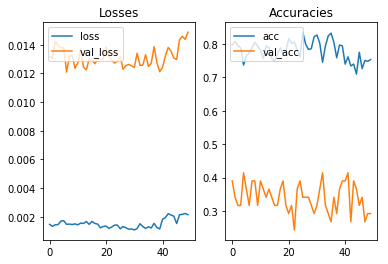

In [184]:
plt.subplot(1,2,1)
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.legend(loc="upper left")
plt.title("Losses")

plt.subplot(1,2,2)
plt.plot(hist.history["acc"], label="acc")
plt.plot(hist.history["val_acc"], label="val_acc")
plt.legend(loc="upper left")
plt.title("Accuracies")

plt.show()

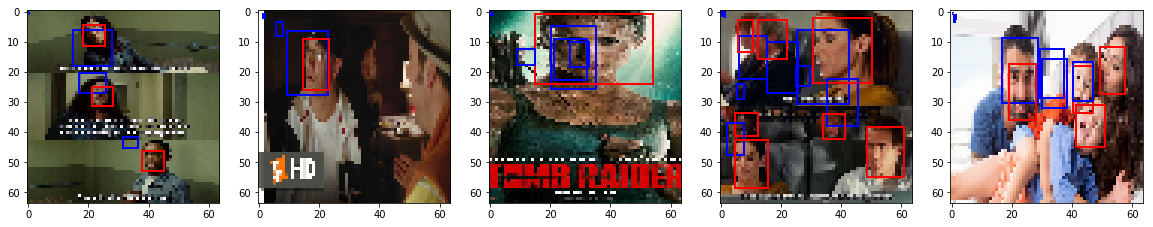

In [187]:
# Test data.
n_test = 5
idx = np.random.permutation(np.arange(len(X_train)))[:n_test]
X_test = X_train[idx]
Y_test = Y_train[idx]
Y_pred = model_cnn.predict(X_test)

#plot predictions
fig = plt.figure(figsize=(20,5))
num_coordinates = len(coordinate_indicies)
for i in range(n_test):
    plt.subplot(1,n_test,i+1)
    img = X_test[i]
    plt.imshow(img)
    #plot actual(red) and predicted(green) boxes.    
    for i_box in range(max_face_count):
        # Predicted in green.
        x,y,w,h = Y_pred[i,i_box*num_coordinates : (i_box+1)*num_coordinates] * target_image_shape[0]
        plt.gca().add_patch(matplotlib.patches.Rectangle(xy=(x,y),width=w,height=h, edgecolor='b', facecolor='none',linewidth=2))
        
        # Actual in red.
        x,y,w,h = Y_test[i,i_box*num_coordinates : (i_box+1)*num_coordinates] * target_image_shape[0]
        plt.gca().add_patch(matplotlib.patches.Rectangle(xy=(x,y),width=w,height=h, edgecolor='r', facecolor='none',linewidth=2))
    #plt.show()
    

### Results
1. Strides=2, padding=valid, No Maxpooling, GlobalAverargePooling: Loss not goot but boxes are good.
2. Strides=1, padding=valid, No Maxpooling, GlobalAverargePooling: Better in terms of loss but not in terms of predicted boxes.
3. Strides=1, padding=same, MaxPool2D, GlobalAverargePooling: Not that good in terms of loss but boxes are better.


4. Strides=2, padding=valid, No Maxpooling, Flatten: Loss not goot but boxes are good.
5. Strides=1, padding=valid, No Maxpooling, Flatten: Loss not goot but boxes are good.
6. Strides=1, padding=same, MaxPool2D, Flatten: Loss not good but boxes are good.

Above results show that architecture for point-6 shows promising results. Thus we deep dive in this architecture.
1. [Strides=1, padding=same, MaxPool2D, Flatten], Increase number of Dense layers: